# Проверка наличия/отсутствия касок у рабочих на предприятиях
## 1. **Загрузка датасета:**

Загрузим датасет с помощью Google Drive:

In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
file_id = '1kimcOWXBP-ILJZmcoVqrRO_QW4ckM0PO'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('/content/HelmetProtection.zip') # Загрузка архива с Google-диска

In [3]:
# Распаковка архива
!unzip -q /content/HelmetProtection.zip -d /content/
!rm /content/HelmetProtection.zip

# Сохранение всех изображений в одну папку all_images
!mkdir /content/HelmetProtection/all_images
!cp -r /content/HelmetProtection/part1/. /content/HelmetProtection/all_images
!cp -r /content/HelmetProtection/part2/. /content/HelmetProtection/all_images
!cp -r /content/HelmetProtection/part3/. /content/HelmetProtection/all_images

!rm -R /content/HelmetProtection/part1/
!rm -R /content/HelmetProtection/part2/
!rm -R /content/HelmetProtection/part3/

HelmetProtection/part2/ıtugae-atolye-(2).jpg:  mismatching "local" filename (HelmetProtection/part2/─▒tugae-atolye-(2).jpg),
         continuing with "central" filename version
HelmetProtection/part2/ıtugae-atolye-(2).json:  mismatching "local" filename (HelmetProtection/part2/─▒tugae-atolye-(2).json),
         continuing with "central" filename version
HelmetProtection/part3/-СЌС‚Р°-e1565174766417.jpg:  mismatching "local" filename (HelmetProtection/part3/-╨б╨М╨бтАЪ╨а┬░-e1565174766417.jpg),
         continuing with "central" filename version
HelmetProtection/part3/-СЌС‚Р°-e1565174766417.json:  mismatching "local" filename (HelmetProtection/part3/-╨б╨М╨бтАЪ╨а┬░-e1565174766417.json),
         continuing with "central" filename version
HelmetProtection/part3/04-05_ZAVOD_-NFCC_РћР»РµРі-РЇРєРѕРІР»РµРІ.jpg:  mismatching "local" filename (HelmetProtection/part3/04-05_ZAVOD_-NFCC_╨а╤Ы╨а┬╗╨а┬╡╨а╤Ц-╨а╨З╨а╤Ф╨а╤Х╨а╨Ж╨а┬╗╨а┬╡╨а╨Ж.jpg),
         continuing with "central" filename version
HelmetProt

## 2. **Подготовка данных к обучению:**

In [4]:
import os
import json
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from PIL import Image, ImageSequence
from tqdm import tqdm
from sklearn.model_selection import train_test_split

Функции для получения данных для обучения:

In [5]:
def get_im_js(path): # получение названий файлов для формирования датасетов
  file_list = os.listdir(path)
  js_files_names = [x[:-5] for x in file_list if x[-5:] == '.json'] # получаем названия json-файлов

  im_files = [x for x in file_list if (x[-5:] != '.json') and (''.join(x.split('.')[:-1]) in js_files_names)] # получаем названия изображений, для которых есть json-файлы, указанные в списке js_files_names
  js_files = [''.join(x.split('.')[:-1]) + '.json' for x in im_files] # получаем названия json-файлов, отсеивая те, для которых нет соответствующих им изображений

  return (im_files, js_files)

def split_and_save(from_path, to_path): # сохраняет обрезанные изображения и возвращает 2 списка их имён (в касках и без)
  im_files, js_files = get_im_js(from_path)
  crop_imgs_k = []
  crop_imgs_nk = []
  for im_name, js_name in tqdm(zip(im_files, js_files)):
    if (im_name[-4:] != '.gif'):
      img = cv2.imread(os.path.join(from_path,im_name))
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
      image = Image.open(os.path.join(from_path,im_name))
      frames = ImageSequence.Iterator(image)
      image = frames[0].copy()
      img = np.array(image.convert('RGB'))
    with open(from_path + js_name, "r") as read_file:
      try:
        data = json.load(read_file)
      except:
        continue
    
    k = 0
    for shape in data['shapes']:
      i1, j1 = np.int32(shape['points'][0][0]), np.int32(shape['points'][0][1])
      i2, j2 = np.int32(shape['points'][1][0]), np.int32(shape['points'][1][1])

      i1, i2 = min(i1,i2), max(i1,i2)
      j1, j2 = min(j1,j2), max(j1,j2)

      file_name = str(k) + ''.join(im_name.split('.')[:-1]) + '.jpg'
      if shape['label'] == 'kaska_on':
        crop_imgs_k.append(file_name)
      else:
        crop_imgs_nk.append(file_name)

      cropped_img = cv2.cvtColor(img[j1:j2,i1:i2,:], cv2.COLOR_RGB2BGR)
      cv2.imwrite(to_path + file_name, cropped_img)
      k += 1

  return (crop_imgs_k, crop_imgs_nk)

In [6]:
# Сохраняем изображения голов в папку all_cropped_images

!rm -R /content/HelmetProtection/all_cropped_images
!mkdir /content/HelmetProtection/all_cropped_images
crop_imgs_k, crop_imgs_nk = split_and_save('/content/HelmetProtection/all_images/', '/content/HelmetProtection/all_cropped_images/')

rm: cannot remove '/content/HelmetProtection/all_cropped_images': No such file or directory


2107it [01:14, 28.11it/s]


In [7]:
# Разбиение даннных на обучающую и тестовую выборки

train_size = 0.8 # доля изображений, которые попадут в обучающую выборку
random_seed = 11

crop_imgs_k_train, crop_imgs_k_test = train_test_split(crop_imgs_k, train_size=train_size, random_state=random_seed) # списки названий изображений для обучающей и тестовой выборок
crop_imgs_nk_train, crop_imgs_nk_test = train_test_split(crop_imgs_nk, train_size=train_size, random_state=random_seed)

In [8]:
def save_data(path, dataset_cl, items): # функция для извлечения изображений из папки data и формирования обучающего и тестового наборов данных
    for item in tqdm(items):
      cmd = 'cp ' + os.path.join(path, item) + ' ' + path + dataset_cl
      os.system(cmd)

In [9]:
!rm -R /content/HelmetProtection/Test
!rm -R /content/HelmetProtection/Train

path = '/content/HelmetProtection/'

datasets = ['Train/', 'Test/']
classes = ['class0/', 'class1/']

for dataset in datasets:
  os.mkdir(path + dataset)
  for cl in classes:
    os.mkdir(path + dataset + cl)

# Сохранение
save_data(path,  datasets[0] + classes[0], ['all_cropped_images/' + x for x in crop_imgs_k_train])
save_data(path,  datasets[1] + classes[0], ['all_cropped_images/' + x for x in crop_imgs_k_test])
save_data(path,  datasets[0] + classes[1], ['all_cropped_images/' + x for x in crop_imgs_nk_train])
save_data(path,  datasets[1] + classes[1], ['all_cropped_images/' + x for x in crop_imgs_nk_test])

rm: cannot remove '/content/HelmetProtection/Test': No such file or directory
rm: cannot remove '/content/HelmetProtection/Train': No such file or directory


100%|██████████| 415/415 [00:24<00:00, 17.28it/s]


In [10]:
!echo Обучающий набор, class0 и class1 соответственно:
!find /content/HelmetProtection/Train/class0 -type f | wc -l
!find /content/HelmetProtection/Train/class1 -type f | wc -l

!echo Тестовый набор, class0 и class1 соответственно:
!find /content/HelmetProtection/Test/class0 -type f | wc -l
!find /content/HelmetProtection/Test/class1 -type f | wc -l

Обучающий набор, class0 и class1 соответственно:
1849
1572
Тестовый набор, class0 и class1 соответственно:
462
403


## 3. **Обучение модели:**

In [11]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.models import Sequential
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Dense, Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC

Воспользуемся генераторами для формирования батчей для обучения и аугментации данных:

In [12]:
training_datagen = ImageDataGenerator(
  rescale = 1./255,
  horizontal_flip=True,
  fill_mode='nearest',
  rotation_range=15.0,
  zoom_range = 0.2,
  width_shift_range=0.2,
  height_shift_range=0.2)

In [13]:
WIDTH = 224
HEIGHT = 224
batch_size = 32

data_dir = '/content/HelmetProtection/Train/'
test_data_dir = '/content/HelmetProtection/Test/'

train_generator = training_datagen.flow_from_directory(data_dir, target_size=(HEIGHT, WIDTH), batch_size=batch_size)
test_generator = training_datagen.flow_from_directory(test_data_dir, target_size=(HEIGHT, WIDTH), batch_size=batch_size)

Found 3421 images belonging to 2 classes.
Found 865 images belonging to 2 classes.


Пример сгенерированного изображения:

(224, 224, 3)
[0. 1.]


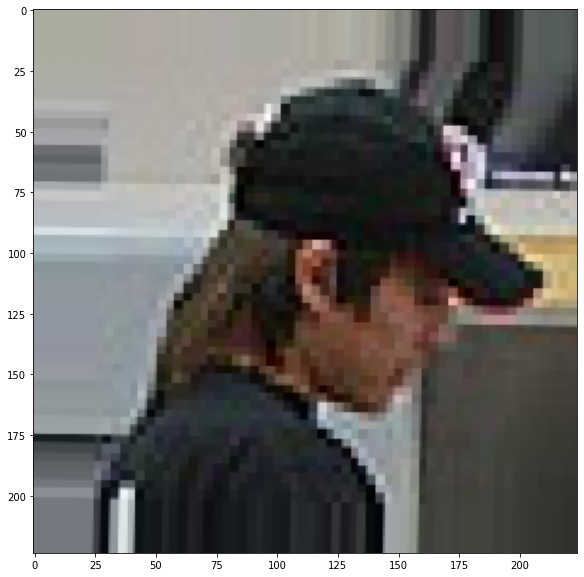

In [14]:
x,y = test_generator.next()
for i in range(0,1):
    image = x[i]
    fig, ax = plt.subplots()
    fig.set_figwidth(10)
    fig.set_figheight(10)
    plt.imshow(image, vmin = 0, vmax = 255)
    print(image.shape)
    print(y[i])

Формируем модель, в качестве базовой архитектуры используем MobileNetV3:

In [15]:
my_model = Sequential()

pretrained_model = MobileNetV3Large(input_shape=(HEIGHT, WIDTH, 3), alpha=0.75, include_top=False,
                                    weights='imagenet', classes=2, pooling='avg', include_preprocessing=False)

for layer in pretrained_model.layers:
        layer.trainable=False

my_model.add(pretrained_model)
my_model.add(Flatten())
my_model.add(Activation('relu'))
my_model.add(Dense(2, activation='softmax'))

my_model.summary()

7938048/7929688 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 720)              1808736   
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 720)               0         
                                                                 
 activation (Activation)     (None, 720)               0         
                                                                 
 dense (Dense)               (None, 2)                 1442      
                                                                 
Total params: 1,810,178
Trainable params: 1,442
Non-trainable params: 1,808,736
_________________________________________________________________


С помощью чекпоинтов реализуем сохранение наилучших результатов:

In [16]:
best_w_acc = ModelCheckpoint('best_result_acc.h5',
                                    monitor='val_accuracy',
                                    verbose=0,
                                    save_best_only=True,
                                    save_weights_only=False,
                                    mode='auto')

last_w = ModelCheckpoint('last_result.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=False,
                                mode='auto')


callbacks = [best_w_acc, last_w]

Компиляция модели и запуск обучения:

***Чтобы не обучать сеть при повторном запуске, в блоке кода после графиков функции потерь и точности (ниже) можно загрузить обученные веса с Github!***

In [17]:
my_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy',AUC()])

history = my_model.fit(train_generator, batch_size=32, validation_data=test_generator, epochs=50, verbose=1, callbacks=callbacks)

Epoch 1/50
107/107 [==============================] - 73s 547ms/step - loss: 0.4452 - accuracy: 0.7892 - auc: 0.8834 - val_loss: 0.3381 - val_accuracy: 0.8566 - val_auc: 0.9393
Epoch 2/50
107/107 [==============================] - 55s 516ms/step - loss: 0.2944 - accuracy: 0.8804 - auc: 0.9543 - val_loss: 0.2830 - val_accuracy: 0.8902 - val_auc: 0.9566
Epoch 3/50
107/107 [==============================] - 56s 523ms/step - loss: 0.2552 - accuracy: 0.8945 - auc: 0.9653 - val_loss: 0.2481 - val_accuracy: 0.9052 - val_auc: 0.9675
Epoch 4/50
107/107 [==============================] - 56s 520ms/step - loss: 0.2304 - accuracy: 0.9100 - auc: 0.9717 - val_loss: 0.2379 - val_accuracy: 0.9006 - val_auc: 0.9680
Epoch 5/50
107/107 [==============================] - 56s 524ms/step - loss: 0.2203 - accuracy: 0.9082 - auc: 0.9735 - val_loss: 0.2276 - val_accuracy: 0.9017 - val_auc: 0.9707
Epoch 6/50
107/107 [==============================] - 60s 557ms/step - loss: 0.2087 - accuracy: 0.9173 - auc: 0.976

Графики функции потерь и точности:

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])


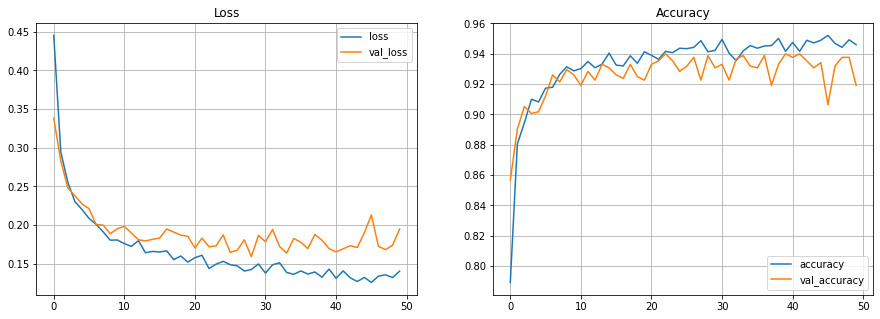

In [18]:
print(history.history.keys())

fig, ax = plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(5)
ax[0].plot(history.history['loss'], label='loss')
ax[0].plot(history.history['val_loss'], label='val_loss')
ax[0].grid()
ax[0].set(title='Loss')
ax[0].legend()

ax[1].plot(history.history['accuracy'], label='accuracy')
ax[1].plot(history.history['val_accuracy'], label='val_accuracy')
ax[1].grid()
ax[1].set(title='Accuracy')
ax[1].legend()

## 4. **Тестирование модели и оценка качества:**

Загрузим веса, соответствующие наибольшой точности:

In [46]:
# Загрузка обученных весов с Github
git_repo_url = 'https://github.com/alimagadovk/MIET.AI.Course'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  !git clone -q $git_repo_url
  !cp '/content/MIET.AI.Course/Лекция 2/Homework/best_result_acc.h5' '/content/'
  !rm -R /content/MIET.AI.Course

In [47]:
my_model.load_weights('best_result_acc.h5')

In [48]:
# Оценка метрик на тестовом наборе данных:

res = my_model.evaluate(test_generator)

28/28 [==============================] - 11s 402ms/step - loss: 0.1749 - accuracy: 0.9341 - auc: 0.9816


Получим матрицу ошибок $\begin{bmatrix}
TP& FN\\
FP& TN
\end{bmatrix}$ ($TP$ - True-Positive, $FN$ - False-Negative, $FP$ - False-Positive, $TN$ - True-Negative) обученной модели для класса 0 - 'в каске', а также построим ROC-кривую:

In [21]:
def get_data(path): # Функция для получения изображений из папки Test и меток для них
  images_names = []
  labels = []
  classes = ['class0/', 'class1/']
  for item in classes:
    images_names += [item + x for x in os.listdir(path + item)]
  images = []
  for name in images_names:
    img = cv2.imread(path + name)
    img = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
    images.append(img / 255.0)
    if name.split('/')[0] == 'class0':
      labels.append(0)
    else:
      labels.append(1)
  return (np.array(images), labels)

In [22]:
(images, labels) = get_data('/content/HelmetProtection/Test/') # Получаем все тестовые изображения и их метки
pred_labels = [np.argmax(x) for x in my_model.predict(images)] # Предсказание сети для тестовых изображений

In [23]:
TP = 0 # True-Positive количество человек в каске, правильно классифицированных сетью
FN = 0 # False-Negative количество человек в каске, неправильно классифицированных сетью (как людей не в касках)
FP = 0 # False-Positive количество человек не в касках, неправильно классифицированных сетью (как людей в касках)
TN = 0 # True-Negative количество человек не в касках, правильно классифицированных сетью (не в каске)

for i in range(len(pred_labels)):
  if (pred_labels[i] == 0) and (labels[i] == 0):
    TP += 1
  elif (pred_labels[i] == 1) and (labels[i] == 0):
    FN += 1
  elif (pred_labels[i] == 0) and (labels[i] == 1):
    FP += 1
  elif (pred_labels[i] == 1) and (labels[i] == 1):
    TN += 1

print('Матрица ошибок класса 0 (в каске):\n', np.array([[TP, FN],[FP, TN]]))

Матрица ошибок класса 0 (в каске):
 [[381  81]
 [ 26 377]]


Так в данной задаче рассматриваются изображения только двух классов, то матрица ошибок для класса 1 может быть получена с помощью перестановки значений на главной диагонали матрицы ошибок класса 0, т. е. имеет вид:

In [24]:
print('Матрица ошибок класса 1 (не в каске):\n', np.array([[TN, FP],[FN, TP]]))

Матрица ошибок класса 1 (не в каске):
 [[377  26]
 [ 81 381]]


In [25]:
from sklearn.metrics import roc_curve, auc

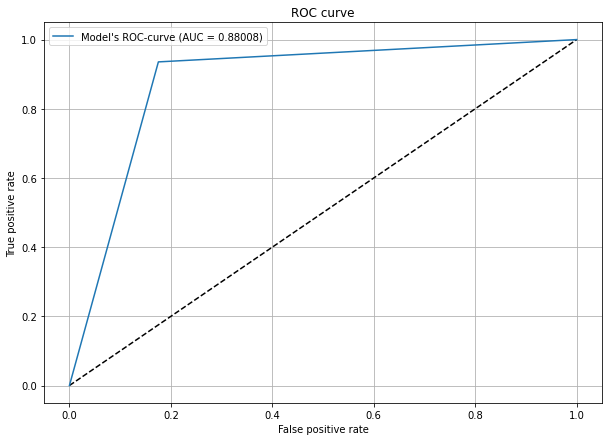

In [26]:
fpr, tpr, _ = roc_curve(labels, pred_labels)
auc_keras = auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label="Model's ROC-curve (AUC = {:.5f})".format(auc_keras))
plt.grid()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Пример работы обученной модели на тестовых изображениях:

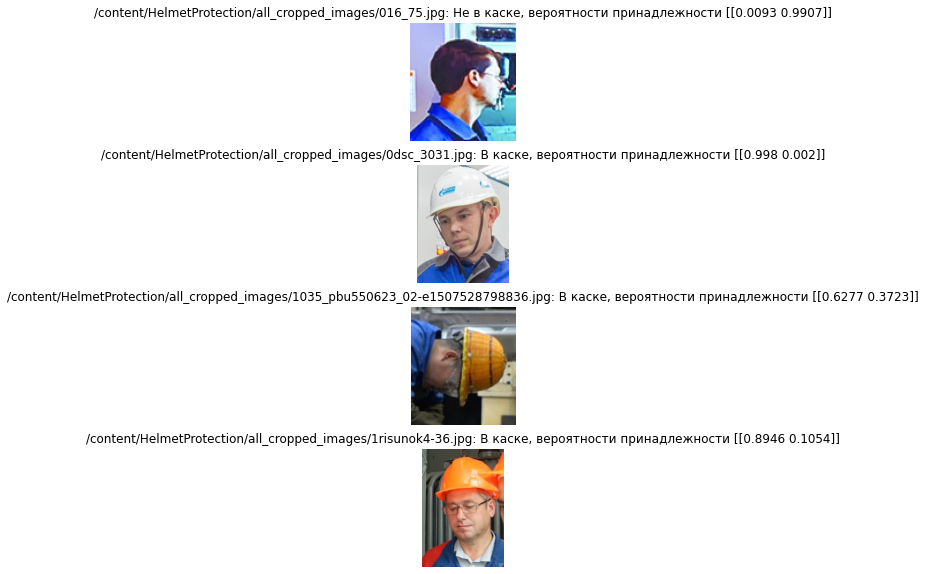

In [27]:
test_dataset = [path + 'all_cropped_images/' + x for x in crop_imgs_k_test + crop_imgs_nk_test]

N = 4
random_imgs = random.sample(test_dataset,N)

dim = (224, 224)
plt.figure(figsize=(10, 10))
for i in range(N):
  img = cv2.imread(random_imgs[i])
  ax = plt.subplot(4, 1, i + 1)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  resized_img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  exp_img = np.expand_dims(resized_img, axis = 0)
  label = my_model.predict(exp_img / 255.)
  if (np.argmax(label) == 0):
    plt.title(random_imgs[i] + ': ' + "В каске, вероятности принадлежности " + str(np.round(label,4)))
  else:
    plt.title(random_imgs[i] + ': ' + "Не в каске, вероятности принадлежности " + str(np.round(label,4)))
  plt.axis("off")

## 5. **MobileNetV3 + OpenPose**

Установка пакетов, необходимых для работы OpenPose:

In [ ]:
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`

Для тестирования комбинации MobileNetV3 + OpenPose получим случайную выборку изображений и сохраним её в папку `validation_dataset`:

In [29]:
!rm -R /content/HelmetProtection/validation_dataset/
!mkdir /content/HelmetProtection/validation_dataset/

N = 30 # кол-во изображений для тестирования
path = '/content/HelmetProtection/all_images/'
random_imgs = random.sample([x for x in os.listdir(path) if x.split('.')[-1] == 'jpg'],N)

for im in tqdm(random_imgs):
  cmd = 'cp ' + os.path.join(path, im) + ' ' + '/content/HelmetProtection/validation_dataset/'
  os.system(cmd)

!rm -R /content/openpose/output
!rm -R /content/openpose/output_images

rm: cannot remove '/content/HelmetProtection/validation_dataset/': No such file or directory


100%|██████████| 30/30 [00:03<00:00,  8.75it/s]


rm: cannot remove '/content/openpose/output': No such file or directory
rm: cannot remove '/content/openpose/output_images': No such file or directory


Оценка поз людей на изображениях из папки `--image_dir`:

In [30]:
!cd openpose && ./build/examples/openpose/openpose.bin --image_dir /content/HelmetProtection/validation_dataset --write_json ./output/ --display 0  --write_images output_images/

Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 60.266323 seconds.


Пример работы обученной модели + оценка положения человека с помощью OpenPose:

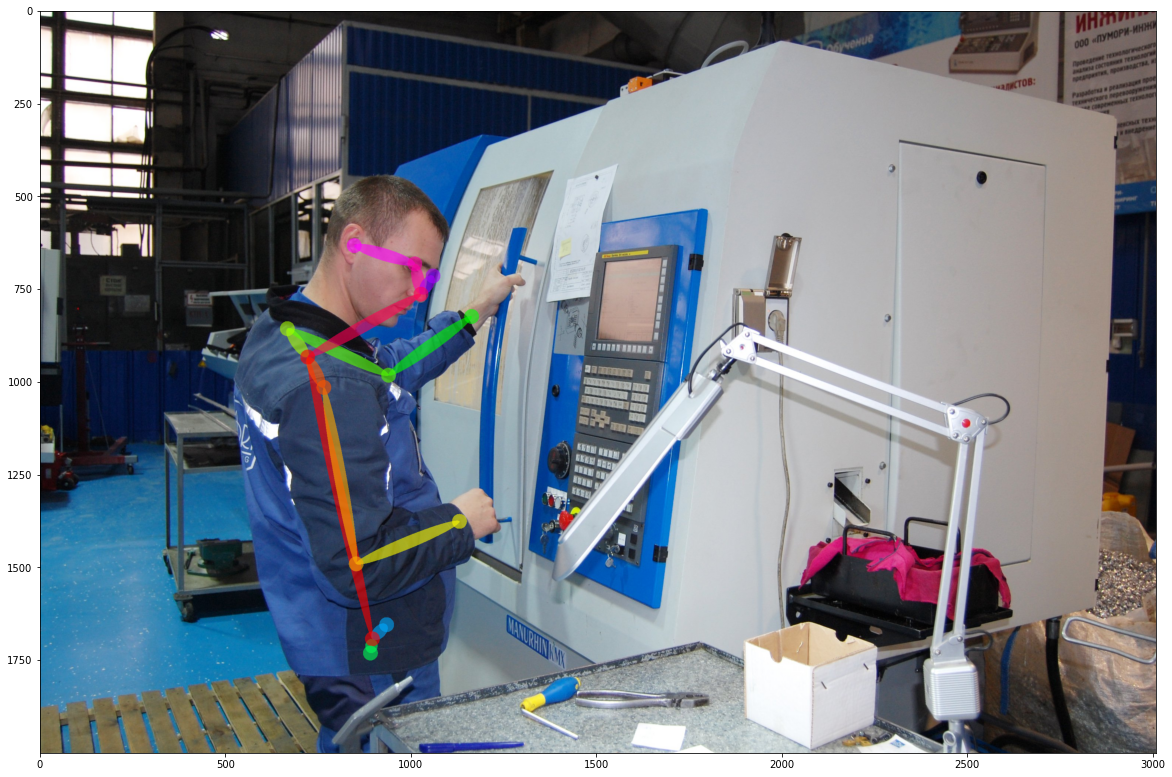

In [31]:
k = 1
im = random_imgs[k]
#im = '5 (1).jpg'

img = cv2.imread(os.path.join(path,im))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

op_path = '/content/openpose/output_images'
op_im = ''.join(im.split('.')[:-1]) + '_rendered.png'
#im = '176624.jpg'
#im = '0_16a5ec_d4df1f1a_XXL.jpg'
#im = '0_17fae0_4acdf9b2_XXL (1).jpg'
#im = '002.jpg'
#im = '0001-6de34e8c-59227e96-81ab-3f55f67d-1.jpg'
#im = '0_f1533_bdc291c9_XXL.jpg'
#im = '11-1-800x450.png'
#im = '1193.jpg'
op_img = cv2.imread(os.path.join(op_path,op_im))
op_img = cv2.cvtColor(op_img, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(20)
plt.imshow(op_img, vmin = 0, vmax = 255)

In [32]:
# Функция для получения координат областей с головами людей на изображении из json-файлов созданных OpenPose

def get_head_rect_op(human, im_shape):
  i_list = human['pose_keypoints_2d'][1::3]
  j_list = human['pose_keypoints_2d'][0::3]

  i_min, i_max = int(min([x for x in i_list if x != 0])), int(max([x for x in i_list if x != 0]))
  j_min, j_max = int(min([x for x in j_list if x != 0])), int(max([x for x in j_list if x != 0]))


  H = i_max - i_min
  W = j_max - j_min

  r = int(W / 2)

  i = (i_min + i_max) // 2 -  H // 2
  j = (j_min + j_max) // 2

  i1, j1 = max(0,i - r), max(0,j - r)
  i2, j2 = min(im_shape[0],i + r), min(im_shape[1],j + r)

  i1, i2 = min(i1,i2), max(i1,i2)
  j1, j2 = min(j1,j2), max(j1,j2)

  point1 = (i1, j1) # up-left
  point2 = (i2, j2) # down-right

  return (point1, point2)


# Функция для получения координат областей с головами людей на изображении из json-файлов обучающего набора

def get_head_rect_data(human):
  j1, i1 = np.int32(human['points'][0][0]), np.int32(human['points'][0][1])
  j2, i2 = np.int32(human['points'][1][0]), np.int32(human['points'][1][1])

  i1, i2 = min(i1,i2), max(i1,i2)
  j1, j2 = min(j1,j2), max(j1,j2)

  point1 = (i1, j1) # up-left
  point2 = (i2, j2) # down-right

  return (point1, point2)

Изображения рабочих с пометкой о наличии/отсутствии каски на голове:

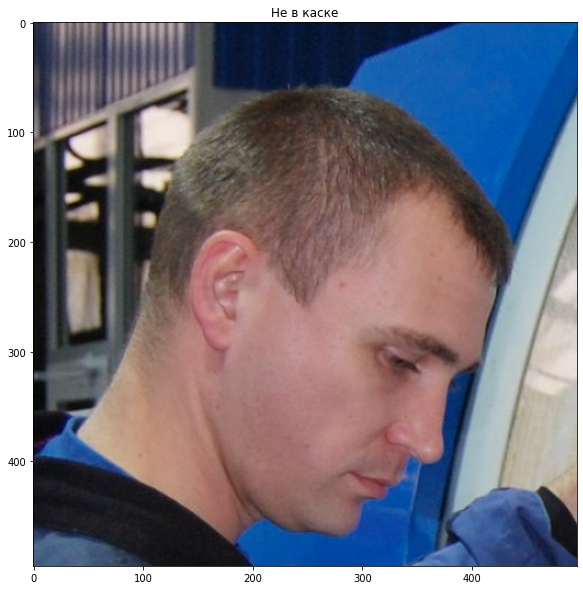

In [33]:
dim = (224, 224)

path_js = '/content/openpose/output/'
js = ''.join(im.split('.')[:-1]) + '_keypoints.json'

with open(path_js + js, "r") as read_file:
  try:
    data = json.load(read_file)
  except:
    print('Не удалось получить информацию о людях на изображении!!!')

for human in data['people']:

  (i1, j1), (i2, j2) = get_head_rect_op(human, img.shape)

  fig, ax = plt.subplots()
  fig.set_figwidth(10)
  fig.set_figheight(10)
  plt.imshow(img[i1:i2,j1:j2,:], vmin = 0, vmax = 255)

  resized_img = cv2.resize(img[i1:i2,j1:j2,:], dim, interpolation = cv2.INTER_AREA)
  exp_img = np.expand_dims(resized_img, axis = 0)
  pred = my_model.predict(exp_img / 255.)
  if (np.argmax(pred) == 0):
    ax.set(title='В каске')
  else:
    ax.set(title='Не в каске')

## 4. **Оценка точности комбинации MobileNetV3 + OpenPose:**

Для оценки точности комбинации моделей *MobileNetV3 + OpenPose*:
1. Cформируем тестовую выборку изображений;
2. Для каждого изображения:
*   Для каждого человека на изображении проверим пересекаются ли области расположения голов, предсказанная OpenPose и указанная в качестве метки в json-файле;
*   Для верно определённых областей применим MobileNetV3, чтобы получить предсказание о наличии/отсутствии каски;
*   Подсчитаем кол-во $S_p$ верных предсказаний, сделанных MobileNetV3;
3. В качестве оценки точности будем рассматривать отношение кол-ва верных предсказаний MobileNetV3 к общему числу людей на изображении $S_r$: $$Accuracy=S_p/S_r$$





In [34]:
def check_rect_intersect(rect1, rect2): # Функция для проверки пересечения областей rect1 и rect2
  (r1_i1, r1_j1), (r1_i2, r1_j2) = rect1
  (r2_i1, r2_j1), (r2_i2, r2_j2) = rect2

  check = not ((r1_i1 > r2_i2) or (r1_j1 > r2_j2) or (r2_i1 > r1_i2) or (r2_j1 > r1_j2))
  return check

In [35]:
# Формируем тестовую выборку

!rm -R /content/HelmetProtection/test_op/
!mkdir /content/HelmetProtection/test_op/ # папка для тестовой выборки


N = 100 # кол-во изображений, для оценки точности
path = '/content/HelmetProtection/all_images/'

# При формировании выборки из неё исключаются файлы, которые могут привести к коллизиям
# (т. е. если в тестовом набор попал файл im.jpg и при этом, например,
# существует файл im.png, либо любого другого формата, но с тем же именем, то тогда
# такие файлы будут исключены из рассмотрения, т. к. они имеют json-файлы
# с одинаковыми именами im.json, а значит нельзя однозначно соспоставить изображение
# json-файлу). Поэтому итоговое число изображений в выборке может быть немного меньше N.

files_list = os.listdir(path)
counter = Counter([''.join(x.split('.')[:-1]) for x in files_list if (''.join(x.split('.')[-1]) != 'json')])
A = list(counter.items())
B = [x[0] for x in A if x[1] > 1]
files_list = [x for x in files_list if not (''.join(x.split('.')[:-1]) in B)]

js_files_names = [x for x in files_list if (x.split('.')[-1] == 'json')] # получаем названия json-файлов
im_files = [x for x in files_list if x.split('.')[-1] != 'json' and (''.join(x.split('.')[:-1]) in [''.join(y.split('.')[:-1]) for y in js_files_names])] # получаем названия изображений, для которых есть json-файлы, указанные в списке js_files_names
js_files = [x for x in js_files_names if (''.join(x.split('.')[:-1]) in [''.join(y.split('.')[:-1]) for y in im_files])] # получаем названия json-файлов, отсеивая те, для которых нет соответствующих им изображений

random_imgs = random.sample(im_files,N)
random_imgs = [x for x in random_imgs if len(x.split('.')) == 2]
random_imgs_names = [''.join(x.split('.')[:-1]) for x in random_imgs]
js_files = [x for x in js_files if ''.join(x.split('.')[:-1]) in random_imgs_names]
js_files = [''.join(x.split('.')[:-1]) + '.json' for x in js_files]


from_path = '/content/HelmetProtection/test_op/'
for im, js in zip(random_imgs, js_files):
  cmd = 'cp ' + os.path.join(path, js) + ' ' + from_path
  os.system(cmd)
  cmd = 'cp ' + os.path.join(path, im) + ' ' + from_path
  os.system(cmd)

random_imgs = [x for x in os.listdir(from_path) if (x.split('.')[-1] != 'json')]
js_files = [x for x in os.listdir(from_path) if (x.split('.')[-1] == 'json')]

rm: cannot remove '/content/HelmetProtection/test_op/': No such file or directory


In [36]:
# Сохраняем предсказания OpenPose

!rm -R /content/HelmetProtection/temp/
!mkdir /content/HelmetProtection/temp/

!rm -R /content/openpose/temp_output
!rm -R /content/openpose/temp_output_images

!rm -R /content/openpose/output
!rm -R /content/openpose/output_images

!mkdir /content/openpose/output
!mkdir /content/openpose/output_images


to_path = '/content/HelmetProtection/temp/temp.jpg'
for item in tqdm(random_imgs):
  cmd = 'cp ' + os.path.join(from_path, item) + ' ' + to_path
  os.system(cmd)
  cmd = 'cd openpose && ./build/examples/openpose/openpose.bin --image_dir /content/HelmetProtection/temp/ --write_json ./temp_output/ --display 0  --write_images temp_output_images/'
  os.system(cmd)
  cmd = 'cp /content/openpose/temp_output_images/temp_rendered.png /content/openpose/output_images/' + ''.join(item.split('.')[:-1]) + '.png'
  os.system(cmd)
  cmd = 'cp /content/openpose/temp_output/temp_keypoints.json /content/openpose/output/' + ''.join(item.split('.')[:-1]) + '.json'
  os.system(cmd)

!rm -R /content/openpose/temp_output
!rm -R /content/openpose/temp_output_images
!rm -R /content/HelmetProtection/temp/

rm: cannot remove '/content/HelmetProtection/temp/': No such file or directory
rm: cannot remove '/content/openpose/temp_output': No such file or directory
rm: cannot remove '/content/openpose/temp_output_images': No such file or directory


100%|██████████| 93/93 [07:22<00:00,  4.76s/it]


In [37]:
# Подсчёт Sr и Sp

pred_path = '/content/openpose/output/'
pred_js = os.listdir(path)

dim = (224, 224)

Sr = 0
Sp = 0

js_files.sort()
random_imgs.sort()

for im, js in zip(random_imgs, js_files):
  with open(from_path + js, "r") as read_file, open(pred_path + js, "r") as read_pred_file:
    data = json.load(read_file)
    pred_data = json.load(read_pred_file)
    img = cv2.imread(from_path + im)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  shapes = data['shapes'].copy()
  humans = pred_data['people'].copy()

  count = 0
  for shape in shapes:
    if shape == None:
      continue
    for human in humans:
      if human == None:
        continue
      rect = get_head_rect_data(shape)
      
      im_shape = img.shape
      pred_rect = get_head_rect_op(human, im_shape)
      if check_rect_intersect(rect, pred_rect):
        if (count == len(shapes)):
          break
        count += 1
        (i1, j1), (i2, j2) = pred_rect
        resized_img = cv2.resize(img[i1:i2,j1:j2,:], dim, interpolation = cv2.INTER_AREA)
        exp_img = np.expand_dims(resized_img, axis = 0)
        pred = my_model.predict(exp_img / 255.)
        if (np.argmax(pred) == 0 and shape['label'] == "kaska_on") or (np.argmax(pred) == 1 and shape['label'] == "kaska_off"):
          Sp += 1
  Sr += len(shapes)

In [38]:
print("Количество верно распознанных людей: ", Sp)
print("Истинное кол-во людей: ", Sr)
print("Точность предсказания: ", Sp / Sr)

Количество верно распознанных людей:  168
Истинное кол-во людей:  188
Точность предсказания:  0.8936170212765957
